<a href="https://colab.research.google.com/github/solara404/Teensy41_Motion_detection/blob/test_branch/fog_ml_training001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Print versions
#!python -h
print('Numpy ' + np.__version__)
#print('TensorFlow ' + tf.__version__)
#print('Keras ' + tf.keras.__version__)

Numpy 1.21.6


In [4]:
# importing test file

#test_data = pd.read_csv('sample_data/testfile_fog.csv')
#data = np.genfromtxt(data, dtype = float, delimiter=',')
#data_2 = pd.read_csv('sample_data/testfile_fog.csv')
#data.head()

#data_csv = pd.read_csv("drive/My Drive/Colab Notebooks/ai_data/fog_data/testfile_fog.csv")
data_txt = pd.read_csv("drive/My Drive/Colab Notebooks/ai_data/fog_data/ex_fog_data_table.txt")
data_txt.head()

,time in sec,bno1 gyro x,bno1 gyro y,bno1 gyro z,bno1 acc x,bno1 acc y,bno1 acc z,bno2 gyro x,bno2 gyro y,bno2 gyro z,...,bno3 gyro z,bno3 acc x,bno3 acc y,bno3 acc z,bno4 gyro x,bno4 gyro y,bno4 gyro z,bno4 acc x,bno4 acc y,bno4 acc z
0,0.000,47,48,13,395,-275,-2328,-223,23,-106,...,-52,-444,-1386,2851,101,-98,-58,1098,2223,889
1,0.009,7,78,23,150,-133,-2389,-303,13,-129,...,-52,-341,-1513,2662,99,-163,-65,1009,2145,977
2,0.019,1,121,26,-97,-31,-2102,-324,-38,-154,...,-64,-173,-1453,2300,86,-267,-59,821,1800,1047
3,0.029,-15,210,14,-486,15,1681,-212,-131,-155,...,-65,-172,-1163,1085,71,-362,-43,993,1327,617
4,0.039,25,292,-7,-280,-82,1718,-111,-105,-38,...,-50,-469,-1077,330,90,-355,-39,1227,494,-313


In [5]:
# pre processing file
precision = 2; # all data values are multiplied by 10 to the power of (precision = 2)


In [6]:
# converting csv to numpy array
data_frames = pd.DataFrame(data_txt)
data = np.array(data_frames)
print(data[0,:])

[    0.    47.    48.    13.   395.  -275. -2328.  -223.    23.  -106.
   -21. -1240.   569.    35.    68.   -52.  -444. -1386.  2851.   101.
   -98.   -58.  1098.  2223.   889.]


In [7]:
# preprocessing data
data = np.delete(data, (0), axis=1) #deleting first row of data (time)
rows, columns = data.shape #getting array shape information

print('nsamples:\t', rows)
print('rows:\t\t', rows)
print('columns:\t', columns)
print('data:\t', data[0,:])

SAMPLES = rows

nsamples:	 1922
rows:		 1922
columns:	 24
data:	 [   47.    48.    13.   395.  -275. -2328.  -223.    23.  -106.   -21.
 -1240.   569.    35.    68.   -52.  -444. -1386.  2851.   101.   -98.
   -58.  1098.  2223.   889.]


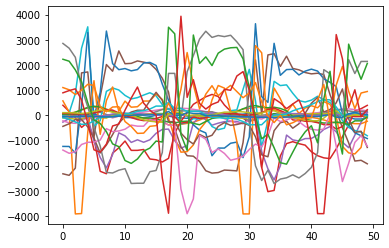

In [8]:
plt.plot(data[:50,:])
#plt.plot(data[:100,3:6])
plt.show()

In [9]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
#TRAIN_SPLIT = int(0.6 * SAMPLES)
#TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
#data_train, data_validate, data_test = np.split(data, [TRAIN_SPLIT, TEST_SPLIT])
#data_train, data_validate, data_test = np.split(data, [TRAIN_SPLIT, TEST_SPLIT])
# Double check that our splits add up correctly
##assert (data_train.size + data_validate.size + data_test.size) == SAMPLES

#print(data_train.size + data_validate.size + data_test.size)
#print(SAMPLES)
#print(TRAIN_SPLIT)
#print(TEST_SPLIT)

split_samples_marker = int(rows * 0.2)
split_validate_marker = int(rows * 0.2)
split_test_marker = int(rows * 0.6)

split_checksum = split_samples_marker + split_validate_marker + split_test_marker

#print(split_checksum)
#print(rows)

while rows > split_checksum:
  split_test_marker += 1
  split_checksum = split_samples_marker + split_validate_marker + split_test_marker
  print("split checksum ", split_checksum)

while rows < split_checksum:
  split_test_marker -= 1
  split_checksum = split_samples_marker + split_validate_marker + split_test_marker
  print("split checksum ", split_checksum)

#print(split_checksum)
#print(rows)

data_train = data[:split_samples_marker, :]
data_validate = data[split_samples_marker:split_samples_marker + split_validate_marker, :]
data_test = data[split_samples_marker+split_validate_marker:, :]

print("size train ", len(data_train))
print("len validate ", len(data_validate))
print("len test ", len(data_test))
print("sum ", len(data_train) + len(data_validate) + len(data_test))


#data[:4,:]

split checksum  1922
size train  384
len validate  384
len test  1154
sum  1922


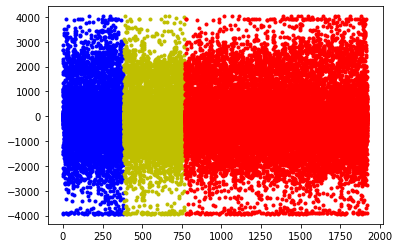

In [10]:
# Plot the data in each partition in different colors:
plt.plot(range(0,split_samples_marker), data_train, 'b.', label="Train")
plt.plot(
    range(split_samples_marker, split_samples_marker + split_validate_marker),
    data_validate, 'y.', label="Validate")
plt.plot(
    range(split_samples_marker + split_validate_marker, 
          split_samples_marker + split_validate_marker + split_test_marker), 
         data_test, 'r.', label="Test")
#plt.legend()
plt.show()

In [11]:
# export data to a folder in magicWand


In [12]:
# Clone the repository from GitHub
!git clone --depth 1 -q https://github.com/stefan-spiss/MagicWand-TFLite-ESP32-MPU6050.git
# Copy the training scripts into our workspace
!git clone https://github.com/solara404/recorded_data.git



Cloning into 'recorded_data'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
